# Interpolating the Libor rate

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · March 2015 (updated on December 2024) · 7 min read

---

## Summary

In this _ipython notebook_ we'll use data from daily reference rates, such as the London interbank interest rate (LIBOR), offered monthly by the Central Bank of Costa Rica (BCCR), to explain some interpolation techniques.

# History

The _London InterBank Offered Rate_ (known for short as LIBOR) was a daily reference rate published daily by Barclays, a British international bank [8], to determine the interest rate of loans (money borrowing) in foreign currencies [4,5]. It consists on a set of four maturity levels (the time until the loan will be charged) for one, three, six or twelve months. Due to a scandal and a legal dispute held in 2012 by the _Commodity Futures Negotiation Commission of the United States (CFTC)_ the LIBOR rate is not used anymore [4,5], but it can still help us to explain how linear interpolation works and other types of interpolation techniques. 

![](img/libor-scandal-headlines-the-financial-times-newspaper-london-august-CTX670.jpg)
![](img/article-2172377-140736A7000005DC-647_634x422.jpg)

Because only four values are published, people require to linearly interpolate intermediate maturity levels, as follows [6]:

$$
y_n = \frac{y_1-y_0}{x_1-x_0} (x_n-x_0) + y_0 \quad (1)
$$

For example, the interest rates at nine months is shown below:

The Libor rate for 8 month(s) is 3.506336666666667.


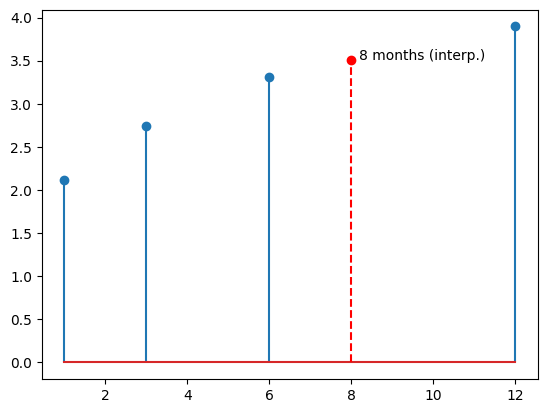

In [2]:
import matplotlib.pylab as plt

x = [1, 3, 6, 12]
y = [2.12029, 2.73757, 3.31129, 3.89643]
plt.stem(x, y)
x_n = 8
y_n = (y[3]-y[2])/(x[3]-x[2]) * (x_n - x[2]) + y[2]
plt.stem(x_n, y_n, '--ro')
plt.annotate(f'{x_n} months (interp.)', [x_n+0.2, y_n])
print(f'The Libor rate for {x_n} month(s) is {y_n}.')

Equation 1 is a hacky solution, since you need to know by forehand the scales in which the new value fits in (indexes 2 and 3 represents six and twelve months in the example above). The indexes can be determined using a sequence of nested IF statements, but is there a more elegant _mathematical_ way to calculate the interpolated values?

## Interpolation kernels

We can answer that question using a mathematical animal called _interpolation kernel_, or $I[n]$. When the interpolation kernel is [convolved](https://en.wikipedia.org/wiki/Convolution) with each sample available the sum of all convolutions provides the interpolated function $\tilde{x}[n]$ [3]: 

$$
    \tilde{x}[n] = \{x*I\}[n] = \sum_{k=-\infty}^{\infty}{x[k]I \left[ \frac{n-kT}{T} \right] }  \quad (2),
$$

where $T$ is the sampling period (in samples). Let's see an example using a trigonometric function:

Discrete frequency: 0.1 samples per second.


<StemContainer object of 3 artists>

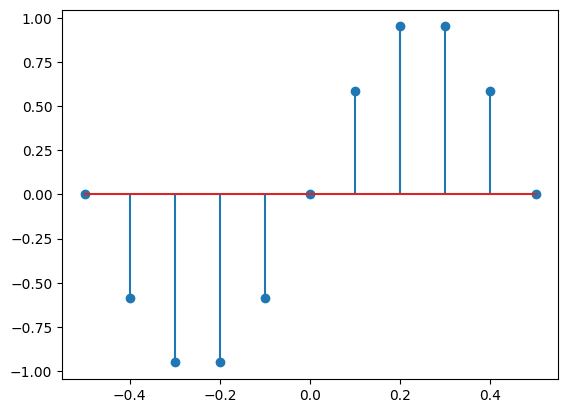

In [57]:
import numpy as np
Fs = 10.0 # Hz
F0 = 1.0 # Hz
print(f'Discrete frequency: {F0/Fs} samples per second.')
x = np.arange(-5, 6)/Fs # two periods for tan, one period for sine/cosine
y = np.sin(2*np.pi*F0*x)
plt.stem(x, y)

We add zeros between the samples (a technique called zero-padding):

<StemContainer object of 3 artists>

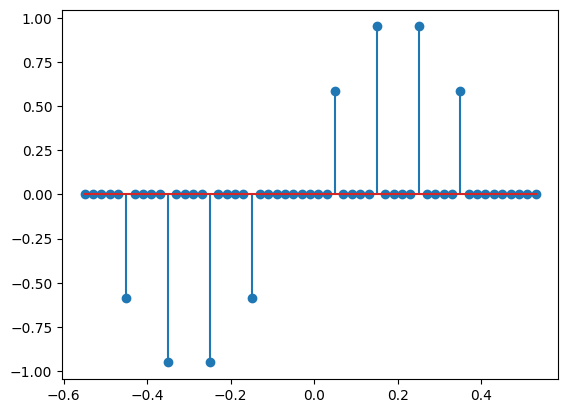

In [58]:
upsampling_factor = 5 # increase the sampling frequency by 5
Fs_p = upsampling_factor*Fs    
y_p = np.zeros(int(len(x)*Fs_p/Fs))
y_p[::int(Fs_p/Fs)] = y
x_p = np.arange(-len(y_p)/2, len(y_p)/2)/Fs_p # one period of the signal
plt.stem(x_p, y_p)

Then we apply equilateral triangles as the interpolation kernels, they become isoceles triangles when the convolution is performed:

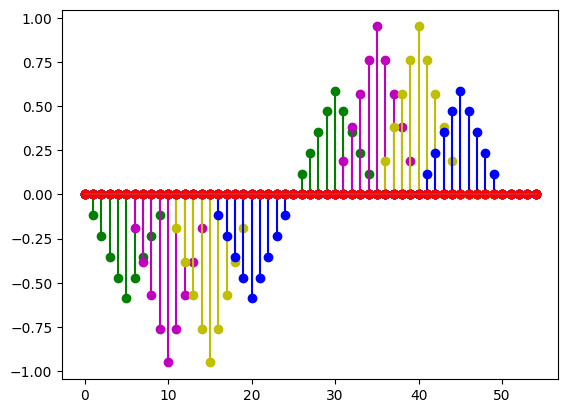

In [86]:
from scipy import signal

def isocelesTriangle(x): 
    return 1.0-np.abs(x) if np.abs(x)<=1 else 0

def triangleKernel(size):
    x = np.linspace(-1, 1, size)
    #return signal.windows.triang(2*upsampling_factor-1)
    return x, [isocelesTriangle(x_i) for x_i in x]

_, kernel = triangleKernel(2*upsampling_factor+1)
y_pp = np.zeros(len(y_p))
colors = ['r', 'g', 'm', 'y', 'b']
for n in range(1, len(y)):
    zeros = np.zeros(len(y_p))
    zeros[n*upsampling_factor] = y[n]
    convolution = np.convolve(zeros, kernel, 'same')
    y_pp += convolution
    plt.stem(convolution, colors[n%len(colors)], markerfmt='%so'%colors[n%len(colors)])

And sum all together:

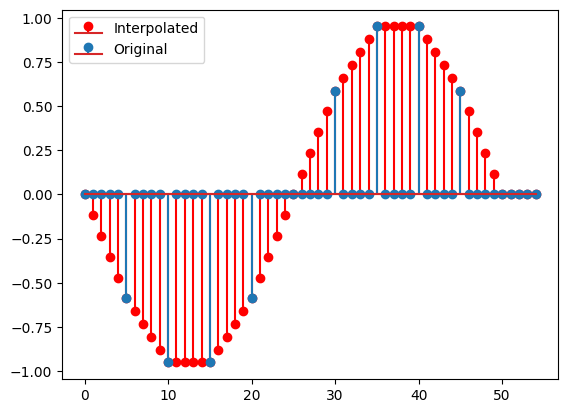

In [87]:
plt.stem(y_pp,'r-')
plt.stem(y_p)
plt.legend(['Interpolated', 'Original'])

As you can see, the interpolating signal is the resulting of "connecting" the dots. 

To apply the same method to the LIBOR rate we need to modify equation 2 a little bit because the LIBOR is not sampled at an uniform sampling rate as $T$ is not the same for all samples (for instance, the distance between six to three months is not the same than the distance between six to twelve); this can be solved using scalene triangles as interpolation kernels. To be continued...

## References:

1. Banco Central de Costa Rica. **Tasa libor 1 mes**. URL: https://gee.bccr.fi.cr/indicadoreseconomicos/Cuadros/frmVerCatCuadro.aspx?idioma=1&CodCuadro=%20334 (last consulted on 04/11/15).

2. LCAV, Ecolé Polytechnique Federale de Lausanne. **Safecast : Band-limited interpolation of radiation measurements in Fukushima** URL: https://nbviewer.jupyter.org/github/LCAV/SignalsOfTheDay/blob/master/Safecast/Safecast.ipynb.

3. P. Prandoni, M. Vertterli. **Signal processing for communications.** EPFL press 2008.

4. Wikipedia contributors. (2019, August 1). Libor scandal. In Wikipedia, The Free Encyclopedia. Retrieved 23:50, August 15, 2019, from https://en.wikipedia.org/w/index.php?title=Libor_scandal&oldid=908807968.

5. Miguel Elizondo. El LIBOR dejará de existir en el 2021. La República.net, Impacto legal. Monday, July 31-th, 2017. URL: https://www.larepublica.net/noticia/el-libor-dejara-de-existir-en-el-2021.

6. Linear interpolation example. International Swaps and Derivatives Association. URL: https://www.isda.org/a/7KiDE/linear-interpolation-example-1-10.pdf.

7. Scipy. Hamming. URL: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.hamming.html (last consulted on 12/31/24).

8. LIBOR. (2024, 10 de noviembre). Wikipedia, La enciclopedia libre. Fecha de consulta: 21:14, noviembre 10, 2024 desde https://es.wikipedia.org/w/index.php?title=LIBOR&oldid=163512053.

## Notes
1. The images were taken from [here](https://i.dailymail.co.uk/i/pix/2012/07/12/article-2172377-140736A7000005DC-647_634x422.jpg) and [here](https://c8.alamy.com/comp/CTX670/libor-scandal-headlines-the-financial-times-newspaper-london-august-CTX670.jpg)

## Appendix 

### Consuming the LIBOR rate from the BCCR SOAP web service

In [ ]:
import matplotlib.pylab as plt
from zeep import Client # SOAP client
import xml.etree.ElementTree as ET # read XMLs
import datetime
import os
import dateutil.parser

def plotLiborRate(liborRateScale: str, liborRateCode: int):
    dicc = client.service.ObtenerIndicadoresEconomicosXML(
        Indicador=liborRateCode, 
        FechaInicio=fechaInicio,
        FechaFinal=fechaFinal,
        Nombre = 'Juan M. Fonseca',
        SubNiveles = 'N',
        CorreoElectronico = 'juanma2268@gmail.com',
        Token = os.environ['BCCR_TOKEN']
    )
    
    # extract the XML that comes embedded in the dictionary data structure
    raiz = ET.fromstring(dicc)
    
    # build the signal
    x = []
    y = []
    for hijo in raiz:
        if 2<len(hijo):    # weekends have no rate
            x.append(dateutil.parser.isoparse(hijo[1].text))
            y.append(float(hijo[2].text))
        
    # plot
    return x, y

'''
Main
'''
client = Client('https://gee.bccr.fi.cr/Indicadores/Suscripciones/WS/wsindicadoreseconomicos.asmx?WSDL')

# Libor rates (https://gee.bccr.fi.cr/indicadoreseconomicos/Documentos/DocumentosMetodologiasNotasTecnicas/Webservices_de_indicadores_economicos.pdf)
liborRateScales = {
    '1': 349,
    '3': 350,
    '6': 351,
    '12': 352,
}

# find the Libor rate since a date in the past
fechaInicio = '01/01/2022'
fechaFinal = '16/07/2022'
liborRates = {}

plt.figure()
for liborRateScale in liborRateScales.keys():
    (dates, rates) = plotLiborRate(liborRateScale, liborRateScales[liborRateScale])
    print(f'Last {liborRateScale} month(s) Libor rates: {rates[-2:]}')
    liborRates[liborRateScale] = {'dates': dates, 'rates': rates}
    plt.plot(dates, rates)

plt.legend(liborRateScales.keys())
plt.xticks(rotation = 45)
plt.xlabel('Days')
plt.show()

---
<a rel="license" href="http://creativecommons.org/licenses/by-nd/4.0/"><img alt="licencia Creative Commons" style="border-width:0" src="img/80x15_by-nd.png" /></a><p style="text-align: center;"> This work is under a <a rel="license" href="http://creativecommons.org/licenses/by-nd/4.0/">Creative Commons Atribución 4.0 Internacional license</a>. The website <a href="https://juanfonsecasolis.github.io/">juanfonsecasolis.github.io</a> It is a Costa Rican blog dedicated to independent research on issues related to digital signal processing. To reuse this article and cite the source you can use Bibtex:</p>
```
@online{Fonseca2015,
  author = {Juan M. Fonseca-Solís},
  title = { Interpolating the Libor rate },
  year = 2015,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.interpolacion.html},
  urldate = {}
}
```

<!-- DISQUIS -->

<div id="disqus_thread"></div>
<script>

/**
*  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
*  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
*/
var disqus_config = function () {
this.page.url = 'https://juanfonsecasolis.github.io/blog/JFonseca.interpolacionBL.html';  // Replace PAGE_URL with your page's canonical URL variable
this.page.identifier = 1; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
};

(function() { // DON'T EDIT BELOW THIS LINE
var d = document, s = d.createElement('script');
s.src = 'https://https-juanfonsecasolis-github-io.disqus.com/embed.js';
s.setAttribute('data-timestamp', +new Date());
(d.head || d.body).appendChild(s);
})();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript">comments powered by Disqus.</a></noscript>
<script id="dsq-count-scr" src="https://https-juanfonsecasolis-github-io.disqus.com/count.js" async></script>